In the previous lecture, we discussed information retrieval and searching by similarity. In brief, those involve specifying a query and looking for objects most similar to the query. Clustering can be thought of as grouping mutually similar objects, sort of finding the intersection of the results of several information retrieval operations.

Clustering partitions data points into groups of similar points. It is a rather vague definition and clustering methods differ by their interpretation of this definition. Another major challenge of clustering is cluster validation. Being an unsupervised method, there is no ground truth from which results can be compared. 

When we perform clustering, there is no guarantee that the resulting clusters will have a specific set of characteristics. This needs to be emphasized: when we do clustering, we can only say the features that the clustering would be based on (e.g, height, age, weight) but there's no guarantee that the clusters would have specific feature values (young, short and chunky; tall, old and skinny). The only guarantee is that the objects in a cluster would be similar.

**Problem 1**

Write down three business problems that could be solved using clustering.

1. **Sales** - Maximizing marketing resources by targeting and grouping of people as one persona (having similar traits) from given consumer population.
2. **Spam filter** - Phishing emails, unwanted and annoying marketing emails can be flagged as spam by clustering parts of email such header, sender and content.
3. **Identifying criminal ativities** - Optimize management of law enforcement resources by identifying high risk - high crime incidence areas over period of time. 

# Sample datasets

We load the same datasets that we used last time. Since we found that normalization improved our results, we will perform standardization as well as take the TF-IDF values.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine, fetch_20newsgroups
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import euclidean, cityblock
from sklearn.base import clone
from numpy.testing import (assert_equal, assert_almost_equal, 
                           assert_array_almost_equal)
from IPython.display import HTML

In [28]:
data_wine = load_wine()
standard_scaler = StandardScaler()
X_wine = standard_scaler.fit_transform(data_wine['data'])
target_wine = data_wine['target']

Let's visualize the wines dataset by plotting the wines as points on a scatterplot. Since each wine has 13 features and a scatterplot has two axes, we reduce them into two using PCA. We will discuss in detail PCA after the lectures on clustering. The points will be colored according to the cultivator, which we use as the ground truth cluster label.

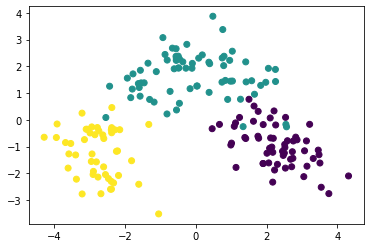

In [29]:
X_wine_new = PCA(n_components=2, random_state=1337).fit_transform(X_wine)
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=target_wine);

We load the newsgroups dataset as well but, this time, we try to clean it by considering words as sequences of alphabetic characters and hyphen. We also remove English stop words. To speed up clustering later, we reduce the number of points by only taking the `test` subset and reduce the number of features by only considering words that occur in at least five posts.

In [30]:
data_newsgroups = fetch_20newsgroups(
    subset='train', 
    categories=['comp.graphics', 'rec.autos'],
    shuffle=False, 
    remove=['headers', 'footers', 'quotes'])
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'[a-z-]+', 
                                   stop_words='english',
                                   min_df=5)
bow_ng = tfidf_vectorizer.fit_transform(data_newsgroups['data'])
nonzeros = bow_ng.sum(axis=1).nonzero()[0]
bow_ng = bow_ng[nonzeros]
target_ng = data_newsgroups['target'][nonzeros]

We visualize them using a scatterplot but we reduce the dimensions first using LSA. Along with PCA, LSA will be discussed after the lectures on clustering. We use the newsgroup as the ground truth cluster label.

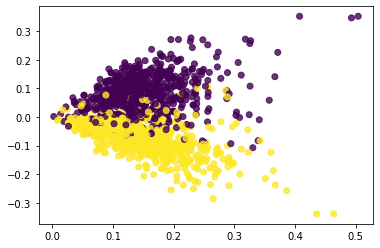

In [31]:
X_ng_new = (TruncatedSVD(n_components=2, random_state=1337)
                .fit_transform(bow_ng))
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=target_ng, alpha=0.8);

# Representative-based clustering

In this notebook, we will explore Representative-based clustering methods. We will also investigate the quality of the clustering using several internal and external validation criteria.

Representative-based clustering methods is a family of clustering methods wherein a representative point, which may or may not be a data point, is assigned for each cluster. Data points are then assigned to the nearest representative after which a new representative is selected for the cluster. The alternating steps of assigning points to a cluster and selecting a representative is repeated until it converges. The algorithm is written more formally below.

**Algorithm** *GenericRepresentative*(Database: $D$, Number of representatives: $k$)  
**begin**  
$\quad$Initialize representative set $S$;  
$\quad$$\quad$**repeat**  
$\quad$$\quad$Create clusters ($C_1, ..., C_k$) by assigning each point in $D$ to closest representative in $S$ using the distance function $Dist(\cdot,\cdot)$  
$\quad$$\quad$Recreate set $S$ by determining one representative $y_j$ for each $C_j$ that minimizes $\sum_{x_i \in C_j} Dist(x_i, y_j)$  
$\quad$**until** convergence;  
$\quad$**return** $(C_i, ..., C_k)$;  
**end**

## $k$-means clustering

The simplest and most popular representative-based clustering method is $k$-means clustering. In this method, the distance function $Dist(\cdot,\cdot)$ is the L2-norm or the squared sum error (SSE), which is just the square of the L2 norm. The representative is chosen to be the mean of the points in the cluster.

Why the mean? Representative-based clustering methods, with $k$ clusters, actually try to minimize the objective function $Q = \sum_{j=1}^k Q_j$ where $Q_j = \sum_{x_i \in C_j} Dist(x_i, y_j)$. For $k$-means, 

$$
Q_j = \sum_{x_i \in C_j} (x_i - y_j)^2.
$$

What should be the value of $y_j$ to minimize $Q_j$? It turns out, it's the mean.

How are the representatives initially selected? The two most common approaches are: 

* randomly assign each data point to a cluster then compute the cluster mean;
* pick $k$ data points and set them as the cluster representative.

The first approach tends to make the representatives closer to the center while the other approach tends to spread them out. There are slight differences in terms of performance but either can be chosen for most cases.

The algorithm has converged if the cluster labels of points do not change after a step.

In `sklearn`, the KMeans class performs $k$-means clustering and it follows the usual fit and predict paradigm.

The result of $k$-means clustering with $k=5$ for the wines dataset is shown below.

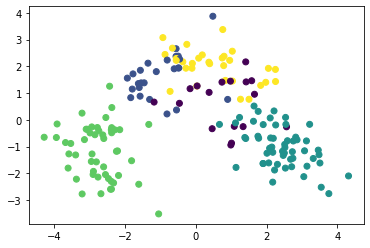

In [32]:
from sklearn.cluster import KMeans
# we tell K-means to partition the points into 5 clusters, which is the number
# of ground-truth clusters
kmeans_wine = KMeans(n_clusters=5, random_state=1337)
y_predict_wine = kmeans_wine.fit_predict(X_wine)
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Problem 2**

What can you say about the clustering? Are you convinced that the clustering is correct? Why or why not?

***Answer:*** <br>
As shown, 5 clusters were observed represented by the colors in the scatterplot, as it was set on the KMeans module.
By using k= 5 n_clusters, both left-most and right-most clusters shows disticnt separation. Eyeballing the 3 clusters on the middle part, even they have a distict portion on the scattering to represent the cultivator label, overlapping is observed.
With this, the clustering may not be fully correct, but can be further optimized by changing the k to 3. Doing so can lead to distinct clusters.

For the newsgroups dataset, the result is shown below.

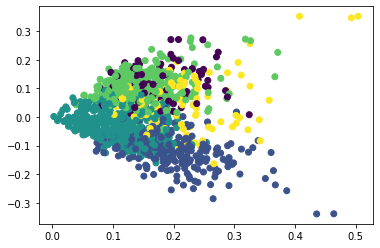

In [33]:
kmeans_ng = KMeans(n_clusters=5, random_state=1337)
y_predict_ng = kmeans_ng.fit_predict(bow_ng)
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

## Cluster validation

What is a good clustering? In general, it has the following desired characteristics:
* **Compact**: points in the same cluster should be close together
* **Separated**: points not belonging in the cluster should be far from points in the cluster
* **Balanced**: the number of points in each cluster are comparable
* **Parsimonious**: the number of cluster should be as few as possible

How do we quantify the quality of our clustering? There are internal and external validation criteria that we can use but none of them gives a definite answer as to whether a clustering is good or bad. In practice, whether or not a clustering is good is determined using several validation criteria, usefulness to the problem being solved and ground truth validation.

### Internal validation criteria

Internal validation means we are not relying on ground truth values to evaluate the quality of the clustering.  Each criterion will favor a clustering method that optimizes a function which is similar to the criterion itself. Thus, comparing totally different clustering methods using a criterion may end up being misleading.

The internal validation criteria that we will use are:

* **Sum of squares distances to centroids**: In the case of $k$-means and other representative-based methods, this is $Q$ and corresponds to the sum of squares distances to the representative points. This is given by the `inertia_` property of `KMeans`. Smaller values suggest better clustering. This is optimized for distance-based algorithms.

* **Calinski-Harabasz index**: Also known as the Variance Ratio Criterion, it is the ratio of the between-clusters dispersion mean and the within-cluster dispersion,
    $$s_k = \frac{B_k/(k-1)}{W_k/(n-k)}$$
    where $B_k$ is the between group dispersion matrix and $W_k$ is the within-cluster dispersion matrix defined by
    $$
    \begin{align}
    B_k &= \sum_{i=1}^k n_i \lvert\lvert \bar x_i - \bar x \rvert\rvert_2^2;\\
    W_k &= \sum_{i=1}^k \sum_{x \in C_i} \lvert\lvert x - \bar x_i \rvert\rvert_2^2,
    \end{align}
    $$
    with $n$ the number of points in our data, $C_i$ the set of points in cluster $i$, $\bar x_i$ the center of cluster $i$, $\bar x$ be the center of all points, $n_i$ be the number of points in cluster $i$ and $n$ be the number of points. The higher the value of this measure, the more defined the clusters are.

* **Intracluster to intercluster distance ratio**: We sample $r$ pairs of data points from the underlying data. We then take the ratio of the average distance of pairs $P$ that belong to the same cluster, and the average distance of pairs $Q$ that belong to different clusters,
$$
Intra/Inter = \frac{\sum_{(x_i, x_j) \in P)} Dist(x_i, x_j)/\left|P\right|}{\sum_{(x_i, x_j) \in Q)} Dist(x_i, x_j)/\left|Q\right|}.
$$
Small values of this measure indicate better clustering behavior.

* **Silhouette coefficient**: Let $Davg^{in}_i$ be the average distance of $x_i$ to data points within the cluster of $x_i$, and $Dmin^{out}_i$ be the smallest average distance to points other than its own cluster. The silhouette coefficient $S_i$ for the $i$th data point specific to the ith object, is as follows: 
    $$
    S_i = \frac{Dmin^{out}_i − Davg^{in}_i}{\max\{{Dmin^{out}_i}, Davg^{in}_i\}}
    $$
    The overall silhouette coefficient is the average of $S_i$. Its value is in the the range (−1,1). Large positive values indicate highly separated clustering, and negative values are indicative of some level of “mixing” of data points from different clusters. This is because $Dmin^{out}_i$ will be less than $Davg^{in}_i$ only in cases where data point $x_i$ is closer to at least one other cluster than its own cluster. One advantage of this coefficient is that the absolute values provide a good intuitive feel of the quality of the clustering.

* **Gap statistic**: This compares the observed within-cluster sum-of-squared-distances with a reference null distribution generated using a Monte Carlo method approach: reference clusterings are created from $b$ realizations of the data. The generated feature value of the reference distribution can be drawn from 
  * a uniform distribution over the range of observed values for that feature;
  * a uniform distribution over a box aligned with the principal components of the data.
  
  We will only implement the first option.
  
  To compute the gap statistic for $k$ clusters, let us first define the pooled within-cluster sum of squares around the cluster mean,
  $$\bar{W}_k = \sum_{i=1}^k \sum_{x \in C_i} \frac{1}{2n_i} \lvert\lvert x - \bar x_i \rvert\rvert_2^2.$$
  This is similar to $W_k$ above but the cluster size is used to normalize the sum-of-squared-distances for each cluster. We then define the gap statistic as
  $$\text{Gap}_n(k) = \frac{1}{b} \sum_i^b \log(\bar{W}_{k,i}) - \log(\bar{W}_k),$$
  where $\bar{W}_{k,i}$ is the $\bar{W}_{k}$ of the $i$th realization.

Except for Gap statistic, all of the criteria are available in sklearn.

**Problem 3**

Create a function `pooled_within_ssd` that returns the pooled within-cluster sum of squares around the cluster mean given the point coordinates, class label, cluster centroids and distance function.

In [34]:
from collections import defaultdict
def pooled_within_ssd(X, y, centroids, dist):
    
    
    """Compute pooled within-cluster sum of squares around the cluster mean
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
        
    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """
    cluster = defaultdict(list)
 
    for i, cluster_i in enumerate(y):
        x1 = X[i]
        x2 = [centroids[j] for j in y][i]
        cluster[cluster_i] += [dist(x1, x2)]

    return sum([np.sum(np.array(v)**2)/(2*len(v)) 
                     for k, v in cluster.items()])

In [35]:
X_test = np.array(
    [[5, 6, 7],
     [8, 9, 10],
     [3, 2, 1],
     [1, 2, 3],
     [4, 5, 6],
     [0, 2, 5],
     [2, 6, 9],
     [8, 3, 5],
     [5, 6, 8],
     [2, 5, 6]]
)
target_test = np.array([0, 1, 2, 1, 0, 2, 2, 1, 0, 1])
centroids_test = np.array(
    [[1, 2, 0],
     [-2, -3, -1],
     [2, -1, 1]]
)
assert_almost_equal(
    pooled_within_ssd(X_test, target_test, centroids_test, euclidean),
    153.33,
    decimal=2
)

**Problem 4**

Create a function `gap_statistic` that returns the gap statistic with its standard deviation given the point coordinates, class label, cluster centroids, distance function, number of realizations for the reference distribution and $k$-means clusterer.

In [36]:
def gap_statistic(X, y, centroids, dist, b, clusterer, random_state=None):
    """Compute the gap statistic
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    b : int
        Number of realizations for the reference distribution
    clusterer : KMeans
        Clusterer object that will be used for clustering the reference 
        realizations
    random_state : int, default=None
        Determines random number generation for realizations
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    rng = np.random.default_rng(random_state)
    # YOUR CODE HERE
    xmin = X.min(axis=0)
    xmax = X.max(axis=0)
    log_ws = []
    for _ in range(b):
        cluster = clone(clusterer)
        cluster.set_params(n_clusters=len(centroids))
        xi = rng.uniform(xmin, xmax, size=X.shape)
        yi = cluster.fit_predict(xi)
        log_ws.append(np.log(pooled_within_ssd(
        xi,yi,cluster.cluster_centers_,dist)))
    return (np.mean(log_ws - 
                   np.log(pooled_within_ssd(X,y,centroids,dist))),
           np.std(log_ws - np.log(pooled_within_ssd(X,y,centroids,dist))))

In [37]:
assert_array_almost_equal(
    gap_statistic(X_test, target_test, centroids_test, euclidean, 5, 
                  KMeans(5, random_state=1337), random_state=1337),
    [-3.231,  0.402],
    decimal=3
)

We now compute the criteria for the clustering that we have just performed.

In [ ]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score
display(HTML('<b>Wine dataset:</b>'))
print(f'Sum of squares distances to centroids: {kmeans_wine.inertia_:.2f}')
print('Calinski-Harabasz: %.2f' % 
      calinski_harabasz_score(X_wine, y_predict_wine))
print('Silhouette coefficient: %.2f' % 
      silhouette_score(X_wine, y_predict_wine))
print('Gap statistic: {:.2f}'.format(
    gap_statistic(X_wine, y_predict_wine, kmeans_wine.cluster_centers_, 
                  euclidean, 5, KMeans(5, random_state=1337), 
                  random_state=1337)))

Sum of squares distances to centroids: 1106.51
Calinski-Harabasz: 47.20
Silhouette coefficient: 0.24


In [26]:
display(HTML('<b>Newsgroups dataset:</b>'))
print(f'Sum of squares distances to centroids: {kmeans_ng.inertia_:.2f}')
print('Calinski-Harabasz: %.2f' % 
      calinski_harabasz_score(bow_ng.todense(), y_predict_ng))
print('Silhouette coefficient: %.2f' % 
      silhouette_score(bow_ng, y_predict_ng))

# Commenting out gap statistic because it takes more than 2 mins to run
# print('Gap statistic: {:.2f}'.format(
#     gap_statistic(bow_ng.todense(), y_predict_ng, kmeans_ng.cluster_centers_, 
#                   euclidean, 5, KMeans(5, random_state=1337), 
#                   random_state=1337)))

Sum of squares distances to centroids: 1075.87
Calinski-Harabasz: 6.54
Silhouette coefficient: 0.01


### External validation criteria

External validation requires ground truth labels and in real life, these are hard to come by. However, since we assumed a ground truth label based on the cultivator and newsgroup, we can use these criteria.

The external validation measures that we will compute are:
* **Cluster purity**: Measures how dominant the dominant class of each ground truth class is. The higher the value the better. Let $m_{ij}$ be the number of data points from ground-truth cluster $i$ that are mapped to cluster $j$, $N_i$ is the number of data points in the ground-truth class $i$, $M_j$ the number of data points in cluster $j$, $k_t$ is the number of ground truth clusters and $k_d$ is the number of clusters determined by the algorithm. We can then write the number of data points in different clusters as
$$
N_i = \sum_{j=1}^{k_d} m_{ij}; \\
M_j = \sum_{i=1}^{k_t} m_{ij}.
$$
The number of data points $P_j$ in the dominant class of cluster $j$ is given by
$$
P_j = \max_i m_{ij}.
$$
We define Purity as
$$
\text{Purity} = \frac{\sum_{j=1}^{k_d} P_j}{\sum_{j=1}^{k_d} M_j}.
$$
High values of Purity are desirable.
* **Adjusted mutual information**: A problem of Purity is that it only considers the dominant class. Adjusted mutual information considers the distribution of all classes. Unlike other mutual information measures, it is also adjusted for chance. For two class labelings $U$ and $V$, the adjusted mutual information is
$$
\text{AMI} = \frac{\text{MI} - E[\text{MI}]}{\max(H[U], H[V]) - E[\text{MI}]}.
$$
The expectation $E[\text{MI}]$ is quite long and can be found [here](https://en.wikipedia.org/wiki/Adjusted_mutual_information#Adjustment_for_chance). Values of AMI is in $[0,1]$ with values close to zero implying the two labelings are independent and a value of 1 indicating that the two label assignments are equal (with or without permutation).
* **Adjusted Rand Index**: The adjusted Rand index is another measure that considers all classes, not just the dominant class. The Rand Index is the sum of the fractions of pairs of elements that are in the same class and should be in the same class, and pairs of elements that are in different classes and should be in different classes. If $C$ is the ground-truth class assignment and $K$ is the clustering, we define $a$ and $b$ as:
  * $a$: the number of pairs of elements that are in the same set in $C$ and in the same set in $K$
  * $b$: the number of pairs of elements that are in different sets in $C$ and in different sets in $K$
The Rand index is then given by
$$
\text{RI} = \frac{a + b}{C_2^{n_{samples}}}
$$
where $C_2^{n_{samples}}$ is the total number of possible pairs in the dataset (without ordering). To adjust for chance, the adjusted Rand index is
$$
\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI}]}.
$$

**Problem 5**

Create a function `purity` that accepts the true and predicted labels then returns the purity.

In [ ]:
from sklearn.metrics import confusion_matrix
def purity(y_true, y_pred):
    """Compute the class purity
    
    Parameters
    ----------
    y_true : array
        List of ground-truth labels
    y_pred : array
        Cluster labels
        
    Returns
    -------
    purity : float
        Class purity
    """
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
assert_almost_equal(
    purity([0, 1, 0, 0, 1, 1, 0, 1, 0, 0], [0, 1, 0, 1, 0, 0, 0, 1, 1, 0]),
    0.6)

The values of the above external validation criteria for the clustering that we did are shown below.

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
display(HTML('<b>Wines dataset:</b>'))
print('Class purity:', purity(target_wine, y_predict_wine))
print('Adjusted mutual info: {:.2f}'.format(
    adjusted_mutual_info_score(target_wine, y_predict_wine)))
print('Adjusted Rand score: %.2f' % 
      adjusted_rand_score(target_wine, y_predict_wine))

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
display(HTML('<b>Newsgroups dataset:</b>'))
print('Class purity:', purity(target_ng, y_predict_ng))
print('Adjusted mutual info: {:.2f}'.format(
    adjusted_mutual_info_score(target_ng, y_predict_ng)))
print('Adjusted Rand score: %.2f' % 
      adjusted_rand_score(target_ng, y_predict_ng))

## Selecting $k$

Let us look at the results for different values of $k$ for the wines dataset.

**Problem 6**

Create a function `cluster_range` that accepts the design matrix, the clustering object, the initial and final values to step through, and, optionally, actual labels. It should return a dictionary of the cluster labels, internal validation values and, if actual labels is given, external validation values, for every $k$. Use a `random_state` of `1337` for all instances where it can be defined.

In [ ]:
def cluster_range(X, clusterer, k_start, k_stop, actual=None):
    ys = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    for k in range(k_start, k_stop+1):
        clusterer_k = clone(clusterer)
        # YOUR CODE HERE
        raise NotImplementedError()
        gs = gap_statistic(X, y, clusterer_k.cluster_centers_, 
                                 euclidean, 5, 
                                 clone(clusterer).set_params(n_clusters=k), 
                                 random_state=1337)
        gss.append(gs[0])
        gssds.append(gs[1])
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
X_test = np.array([[5, 6, 7],
                   [8, 9, 10],
                   [3, 2, 1],
                   [1, 2, 3],
                   [4, 5, 6],
                   [0, 2, 5],
                   [2, 6, 9],
                   [8, 3, 5],
                   [5, 6, 8],
                   [2, 5, 6]])
target_test = np.array([0, 1, 2, 1, 0, 2, 2, 1, 0, 1])
res = cluster_range(X_test, KMeans(random_state=42), 2, 5)
assert_equal(
    sorted(res.keys()), 
    ['chs', 'gss', 'gssds', 'inertias', 'scs', 'ys'])
res = cluster_range(X_test, KMeans(random_state=42), 2, 5, target_test)
assert_equal(
    sorted(res.keys()), 
    ['amis', 'ars', 'chs', 'gss', 'gssds', 'inertias', 'ps', 'scs', 'ys'])
assert_array_almost_equal(res['ps'], [0.5, 0.6, 0.7, 0.7])
assert_array_almost_equal(
    res['gss'], [0.02 , 0.075, 0.106, 0.352], decimal=3)

In [ ]:
res_wine = cluster_range(X_wine, KMeans(random_state=1337), 2, 11, 
                         actual=target_wine)

In [ ]:
def plot_clusters(X, ys):
    """Plot clusters given the design matrix and cluster labels"""
    k_max = len(ys) + 1
    k_mid = k_max//2 + 2
    fig, ax = plt.subplots(2, k_max//2, dpi=150, sharex=True, sharey=True, 
                           figsize=(7,4), subplot_kw=dict(aspect='equal'),
                           gridspec_kw=dict(wspace=0.01))
    for k,y in zip(range(2, k_max+1), ys):
        if k < k_mid:
            ax[0][k%k_mid-2].scatter(*zip(*X), c=y, s=1, alpha=0.8)
            ax[0][k%k_mid-2].set_title('$k=%d$'%k)
        else:
            ax[1][k%k_mid].scatter(*zip(*X), c=y, s=1, alpha=0.8)
            ax[1][k%k_mid].set_title('$k=%d$'%k)
    return ax

In [ ]:
plot_clusters(X_wine_new, res_wine['ys']);

**Problem 7**

Based on the plots above, what is the best value for $k$? Justify your choice.

YOUR ANSWER HERE

Aside from eyeballing or using domain expertise, we can select the value of $k$ by evaluating several internal validation criteria for each value of $k$. Note, however, that none of these criteria provide a definite value of $k$ and will still be set based on the goals of the problem. We plot the different criteria below.

In [ ]:
def plot_internal(inertias, chs, scs, gss, gssds):
    """Plot internal validation values"""
    fig, ax = plt.subplots()
    ks = np.arange(2, len(inertias)+2)
    ax.plot(ks, inertias, '-o', label='SSE')
    ax.plot(ks, chs, '-ro', label='CH')
    ax.set_xlabel('$k$')
    ax.set_ylabel('SSE/CH')
    lines, labels = ax.get_legend_handles_labels()
    ax2 = ax.twinx()
    ax2.errorbar(ks, gss, gssds, fmt='-go', label='Gap statistic')
    ax2.plot(ks, scs, '-ko', label='Silhouette coefficient')
    ax2.set_ylabel('Gap statistic/Silhouette')
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines+lines2, labels+labels2)
    return ax

In [ ]:
plot_internal(res_wine['inertias'], res_wine['chs'], res_wine['scs'], 
              res_wine['gss'], res_wine['gssds'])

Since we're assuming ground truth labels, we also plot the external validation values below.

In [ ]:
def plot_external(ps, amis, ars):
    """Plot external validation values"""
    fig, ax = plt.subplots()
    ks = np.arange(2, len(ps)+2)
    ax.plot(ks, ps, '-o', label='PS')
    ax.plot(ks, amis, '-ro', label='AMI')
    ax.plot(ks, ars, '-go', label='AR')
    ax.set_xlabel('$k$')
    ax.set_ylabel('PS/AMI/AR')
    ax.legend()
    return ax

In [ ]:
plot_external(res_wine['ps'], res_wine['amis'], res_wine['ars']);

**Problem 8**

Perform $k$-means clustering on the newsgroups datasets. What is the best value of $k$ and why?

# $k$-medians clustering

A disadvantage of using $k$-means is that, since it is using L2-norm, it can be susceptible to outliers. One way to make it more robust is to use the L1-norm instead. It turns out the best representative for this case is the median hence the name.

In [ ]:
from pyclustering.cluster.kmedians import kmedians
# we set k=5 and pick the first 5 points as the initial representatives
kmd = kmedians(X_wine, X_wine[:5,:], ccore=False)
kmd.process()
clusters = kmd.get_clusters()
y_predict = np.zeros(len(X_wine))
for cluster, point in enumerate(clusters):
    y_predict[point] = cluster

In [ ]:
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict);

We can also try different values of $k$ as before.

**Problem 9**

Create a function `gap_statistic_kmedians` that will compute the gap statistic for $k$-medians.

In [ ]:
def gap_statistic_kmedians(X, y, centroids, b):
    """Compute the gap statistic for a k-medians clusterer
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    b : int
        Number of realizations for the reference distribution
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    np.random.seed(1337)
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
X_test = np.array(
    [[5, 6, 7],
     [8, 9, 10],
     [3, 2, 1],
     [1, 2, 3],
     [4, 5, 6],
     [0, 2, 5],
     [2, 6, 9],
     [8, 3, 5],
     [5, 6, 8],
     [2, 5, 6]]
)
target_test = np.array([0, 1, 2, 1, 0, 2, 2, 1, 0, 1])
centroids_test = np.array(
    [[1, 2, 0],
     [-2, -3, -1],
     [2, -1, 1]]
)
assert_array_almost_equal(
    gap_statistic_kmedians(X_test, target_test, centroids_test, 5),
    [-3.324,  0.29],
    decimal=3
)

**Problem 10**

Create a function `cluster_range_kmedians` that accepts the design matrix, the initial and final values to step through, and, optionally, actual labels. It should return a dictionary of the cluster labels, internal validation values and, if actual labels is given, external validation values, for every $k$.

In [ ]:
def cluster_range_kmedians(X, k_start, k_stop, actual=None):
    ys = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    for k in range(k_start, k_stop+1):
        clusterer_k = kmedians(X, X[:k,:], ccore=False)
        # YOUR CODE HERE
        raise NotImplementedError()
        gs = gap_statistic_kmedians(X, y, clusterer_k.get_medians(), 5)
        gss.append(gs[0])
        gssds.append(gs[1])
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
X_test = np.array([[5, 6, 7],
                   [8, 9, 10],
                   [3, 2, 1],
                   [1, 2, 3],
                   [4, 5, 6],
                   [0, 2, 5],
                   [2, 6, 9],
                   [8, 3, 5],
                   [5, 6, 8],
                   [2, 5, 6]])
target_test = np.array([0, 1, 2, 1, 0, 2, 2, 1, 0, 1])
res = cluster_range_kmedians(X_test, 2, 5)
assert_equal(
    sorted(res.keys()), 
    ['chs', 'gss', 'gssds', 'inertias', 'scs', 'ys'])
res = cluster_range_kmedians(X_test, 2, 5, target_test)
assert_equal(
    sorted(res.keys()), 
    ['amis', 'ars', 'chs', 'gss', 'gssds', 'inertias', 'ps', 'scs', 'ys'])
assert_array_almost_equal(
    res['gss'], 
    [0.003,  0.124,  0.217, -0.190],
    decimal=3)
assert_array_almost_equal(res['ps'], [0.4, 0.6, 0.6, 0.7])

In [ ]:
res_wine = cluster_range_kmedians(X_wine, 2, 11, actual=target_wine)

In [ ]:
plot_clusters(X_wine_new, res_wine['ys']);

In [ ]:
plot_internal(res_wine['inertias'], res_wine['chs'], res_wine['scs'], 
              res_wine['gss'], res_wine['gssds'])

In [ ]:
plot_external(res_wine['ps'], res_wine['amis'], res_wine['ars']);

**Problem 11**

Perform $k$-medians clustering on the newsgroups datasets. What is the best value of $k$ and why?

YOUR ANSWER HERE

# $k$-medoids clustering

A problem with $k$-means and $k$-medians is that the cluster representative need not be a data point. $k$-medoids works around this problem by enforcing that only data points can be chosen as a representative. This would then allow us to work with categorical variables as long as a suitable distance measure is used.

In [ ]:
from pyclustering.cluster.kmedoids import kmedoids
# we set k=5 and pick the first 5 points as the initial representatives
kmo = kmedoids(X_wine, np.arange(5), ccore=False)
kmo.process()
clusters = kmo.get_clusters()
y_predict = np.zeros(len(X_wine))
for cluster, point in enumerate(clusters):
    y_predict[point] = cluster

In [ ]:
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict);

**Problem 12**

Create a function `gap_statistic_kmedoids` that will compute the gap statistic for $k$-medians.

In [ ]:
def gap_statistic_kmedoids(X, y, centroids, b):
    """Compute the gap statistic for a k-medoids clusterer
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    b : int
        Number of realizations for the reference distribution
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    np.random.seed(1337)
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
X_test = np.array(
    [[5, 6, 7],
     [8, 9, 10],
     [3, 2, 1],
     [1, 2, 3],
     [4, 5, 6],
     [0, 2, 5],
     [2, 6, 9],
     [8, 3, 5],
     [5, 6, 8],
     [2, 5, 6]]
)
target_test = np.array([0, 1, 2, 1, 0, 2, 2, 1, 0, 1])
centroids_test = np.array(
    [[1, 2, 0],
     [-2, -3, -1],
     [2, -1, 1]]
)
assert_array_almost_equal(
    gap_statistic_kmedoids(X_test, target_test, centroids_test, 5),
    [-0.872, 0.282],
    decimal=3
)

**Problem 13**

Create a function `cluster_range_kmedoids` that accepts the design matrix, the initial and final values to step through, and, optionally, actual labels. It should return a dictionary of the cluster labels, internal validation values and, if actual labels is given, external validation values, for every $k$.

In [ ]:
def cluster_range_kmedoids(X, k_start, k_stop, actual=None):
    ys = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    for k in range(k_start, k_stop+1):
        clusterer_k = kmedoids(X, np.arange(k), ccore=False)
        # YOUR CODE HERE
        raise NotImplementedError()
        gs = gap_statistic_kmedoids(X, y, X[centers], 5)
        gss.append(gs[0])
        gssds.append(gs[1])
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
X_test = np.array([[5, 6, 7],
                   [8, 9, 10],
                   [3, 2, 1],
                   [1, 2, 3],
                   [4, 5, 6],
                   [0, 2, 5],
                   [2, 6, 9],
                   [8, 3, 5],
                   [5, 6, 8],
                   [2, 5, 6]])
target_test = np.array([0, 1, 2, 1, 0, 2, 2, 1, 0, 1])
res = cluster_range_kmedoids(X_test, 2, 5)
assert_equal(
    sorted(res.keys()), 
    ['chs', 'gss', 'gssds', 'inertias', 'scs', 'ys'])
res = cluster_range_kmedoids(X_test, 2, 5, target_test)
assert_equal(
    sorted(res.keys()), 
    ['amis', 'ars', 'chs', 'gss', 'gssds', 'inertias', 'ps', 'scs', 'ys'])
assert_array_almost_equal(
    res['gss'], 
    [1.557, 2.341, 2.845, 2.684],
    decimal=3)
assert_array_almost_equal(res['ps'], [0.4, 0.6, 0.6, 0.7])

In [ ]:
res_wine = cluster_range_kmedoids(X_wine, 2, 11, actual=target_wine)

In [ ]:
plot_clusters(X_wine_new, res_wine['ys']);

In [ ]:
plot_internal(res_wine['inertias'], res_wine['chs'], res_wine['scs'],
              res_wine['gss'], res_wine['gssds'])

In [ ]:
plot_external(res_wine['ps'], res_wine['amis'], res_wine['ars']);

# References
* C. Shalizi, Statistics 36-350 lecture notes, http://www.stat.cmu.edu/~cshalizi/350/lectures/07/lecture-07.pdf
* C. Aggarwal, Data Mining: The Textbook, Chapter 6.
* R. Tibshirani, G. Walther, and T. Hastie. _Estimating the number of clusters in a data set via the gap statistic._ Journal of the Royal Statistical Society: Series B (Statistical Methodology), 63(2), 411-423, 2001.